Create compression version of GPT-2 nad BERT model and save the memory =)

## stsb example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
#import torch
#torch.manual_seed(2)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [3]:
#!pip install Partial State

In [4]:
import transformers
print (transformers.__version__)

4.30.2


In [5]:
#!pip install datasets evaluate

In [6]:
#!pip3 install --upgrade pip
#!pip3 install --upgrade transformers

In [7]:
from datasets import load_dataset
import pandas as pd

dataset_stsb = load_dataset('glue', 'stsb')
dataset_stsb.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 5749, 'validation': 1500, 'test': 1379}

In [8]:
len(pd.DataFrame(dataset_stsb['train']))

5749

In [9]:
task_num_labels = 1

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=task_num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [10]:
from sparse_grad2 import replace_bert_layers

def sparse_grad_linear(model, *args):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model)
    print ("created bert with sparse grads")
    return model

In [11]:
model = sparse_grad_linear(model)

create bert with sparse grads
created bert with sparse grads


In [12]:
def convert_to_stsb_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=128, truncation=True, padding="max_length")
    features["labels"] = example_batch["label"]
    return features

In [13]:
tokenized_dataset = dataset_stsb.map(
            convert_to_stsb_features,
            batched=True,
            load_from_cache_file=False,
            )

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [14]:
len(tokenized_dataset['train'])

5749

In [15]:
from torch.utils.data import DataLoader, RandomSampler

eval_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=10)


In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import torch 

from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

class TrainerBert1(Trainer):
    
    def make_grad_bank(self):
        self.n_show = 3
        self.losses = []
    
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        for layer in range(12):
                
            if (model.bert.encoder.layer[layer].output.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].output.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].output.dense.weight.grad
                model.bert.encoder.layer[layer].output.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))

            if (model.bert.encoder.layer[layer].intermediate.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].intermediate.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].intermediate.dense.weight.grad
                model.bert.encoder.layer[layer].intermediate.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))
                

            else:
                
                if (self.n_show > 0):
                    self.n_show -= 1
                    im= plt.imshow(model.bert.encoder.layer[layer].output.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].output.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show))
                    plt.colorbar(im) #not in spy
                    plt.show()
                    #plt.colorbar(im2)
                    #plt.show()
                    #plt.colorbar(im3)
                    #plt.show()
                    #plt.colorbar(im4)
                    #plt.show()
                    #plt.colorbar(im5)
                    plt.show()

                    im= plt.imshow(model.bert.encoder.layer[layer].intermediate.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].intermediate.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()
                
                    
        
        

        self.losses.append(loss.cpu().detach().numpy())
        return loss.detach()

2023-07-20 20:26:17.782523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [18]:
metric = ev.load("glue", 'stsb')

In [19]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.squeeze(preds_)

        result = metric.compute(predictions=preds_, 
                                references=p.label_ids)
        if len(result) > 1:
            result["combined_score"] = np.mean(list(result.values())).item()
        return result

In [20]:
training_args = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [21]:
trainer = TrainerBert1(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics
)
trainer.make_grad_bank()
trainer.args._n_gpu=1

# regular bert

len small dataset 5749
lets collect gradients
number of nonzero  tensor(2359296)


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


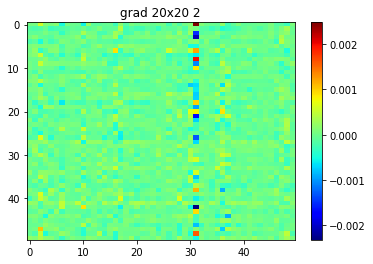

number of nonzero  tensor(2359296)


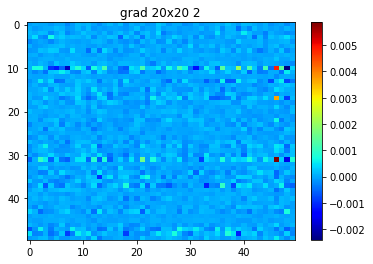

number of nonzero  tensor(2359296)


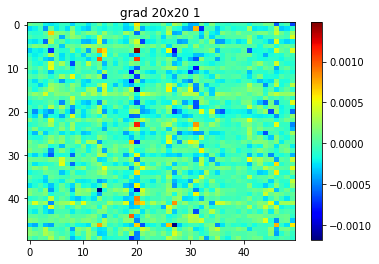

number of nonzero  tensor(2359296)


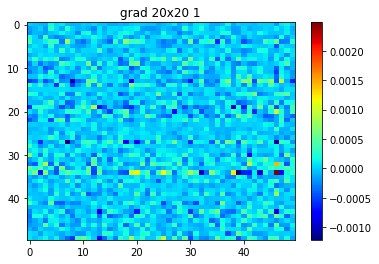

number of nonzero  tensor(2359296)


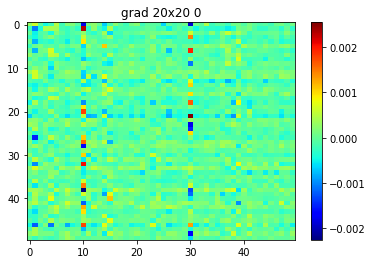

number of nonzero  tensor(2359296)


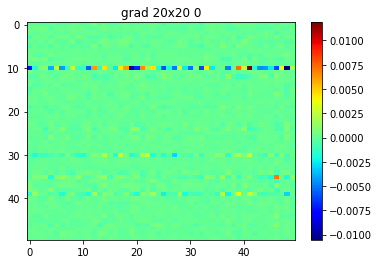

Step,Training Loss,Validation Loss


In [ ]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [ ]:
eval_losses = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]
import pickle
with open('./stsb_pickles/bert_eval.pkl', 'wb') as f:
    pickle.dump(np.array(trainer.losses), f)

# sparse bert

len small dataset 5749
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Pearson,Spearmanr,Combined Score
100,No log,0.599567,0.856987,0.849969,0.853478
200,No log,0.560787,0.867574,0.863428,0.865501
300,No log,0.555736,0.870378,0.864535,0.867457
400,No log,0.523775,0.876491,0.871304,0.873898
500,0.764500,0.537511,0.878234,0.873717,0.875976
600,0.764500,0.539094,0.875961,0.872371,0.874166
700,0.764500,0.524659,0.877069,0.872950,0.875009


created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
number of nonzero  tensor(2359296)


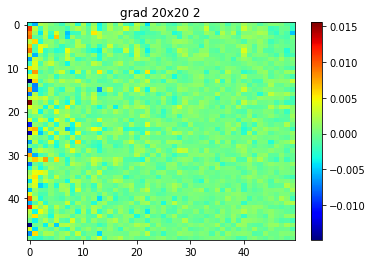

number of nonzero  tensor(2359296)


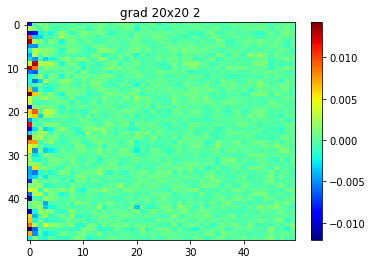

number of nonzero  tensor(2359296)


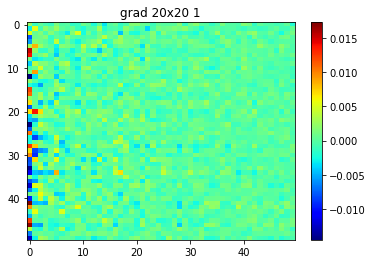

number of nonzero  tensor(2359296)


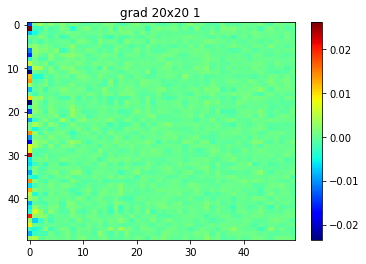

number of nonzero  tensor(2359296)


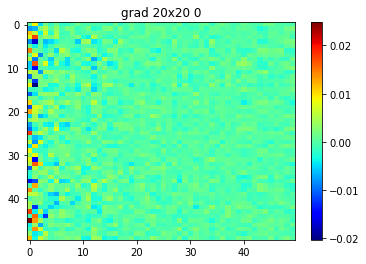

number of nonzero  tensor(2359296)


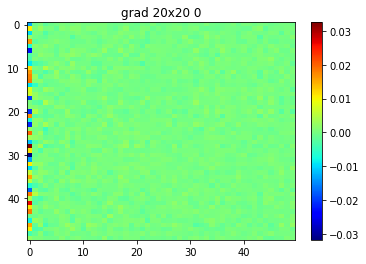

finishing collecting gradients


In [21]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [ ]:
import pickle
a = pickle.load( open( "./stsb_pickles/bert_sparse.pkl", "rb" ) ) 
b = pickle.load( open( "./stsb_pickles/regular_bert.pkl", "rb" ) ) 

In [22]:
eval_losses = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]
import pickle
with open('./stsb_pickles/sparse_bert_eval.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [23]:
import pickle
with open('./stsb_pickles/sparse_bert.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [ ]:
#VT transpose
#plt.plot(np.mean(np.array(a)[:350].reshape(-1, 10), axis=1), label = "bert in new basis")
plt.plot(np.mean(np.array(b)[:350].reshape(-1, 10), axis=1), label = "regular bert")
plt.plot(np.mean(np.array(trainer.losses)[:1050].reshape(-1, 10), axis=1), label = "bert sparse")
plt.legend()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.evaluate()

In [ ]:
import pickle
with open('./stsb_pickles/regular_bert.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [ ]:
trainer.state.log_history[2]['eval_loss']

# sparse bert trh 001

len small dataset 5749
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Pearson,Spearmanr,Combined Score
100,No log,0.686889,0.834365,0.835757,0.835061
200,No log,0.643153,0.848738,0.847984,0.848361
300,No log,0.621865,0.858754,0.853542,0.856148
400,No log,0.567872,0.865341,0.860840,0.863090
500,0.845700,0.573674,0.865602,0.861218,0.863410
600,0.845700,0.587104,0.866888,0.863032,0.864960
700,0.845700,0.569415,0.867161,0.862823,0.864992


created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
number of nonzero  tensor(20293)


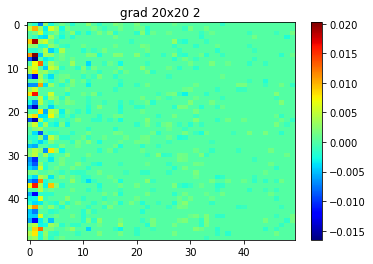

number of nonzero  tensor(18198)


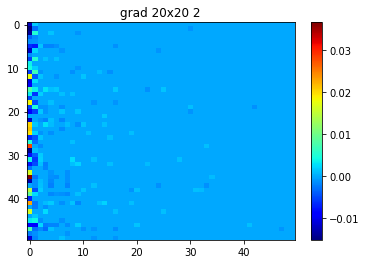

number of nonzero  tensor(26819)


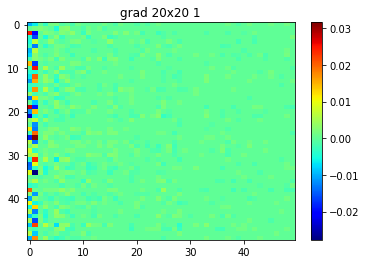

number of nonzero  tensor(38491)


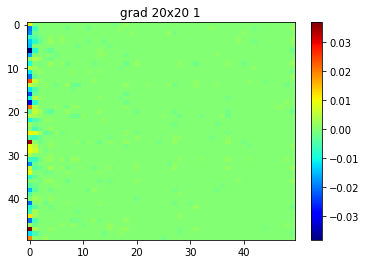

number of nonzero  tensor(29811)


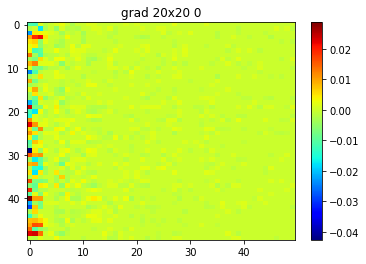

number of nonzero  tensor(44304)


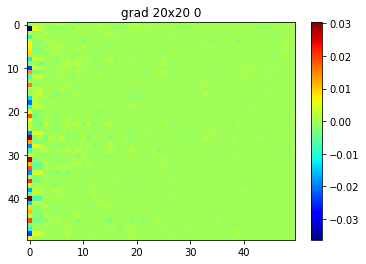

finishing collecting gradients


In [22]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [23]:
eval_losses = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]
import pickle
with open('./stsb_pickles/sparse_bert0001_eval.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [24]:
import pickle
with open('./stsb_pickles/sparse_bert0001.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [26]:
trainer.evaluate()

{'eval_loss': 0.5826223492622375,
 'eval_pearson': 0.8670191755734422,
 'eval_spearmanr': 0.8629409826580795,
 'eval_combined_score': 0.8649800791157609,
 'eval_runtime': 4.6745,
 'eval_samples_per_second': 320.893,
 'eval_steps_per_second': 2.567,
 'epoch': 2.0}

# sparse bert trh 01

In [ ]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [22]:
eval_losses = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]
import pickle
with open('./stsb_pickles/sparse_bert01_eval.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [23]:
import pickle
with open('./stsb_pickles/sparse_bert01.pkl', 'wb') as f:
    pickle.dump(np.array(trainer.losses), f)

# sparse bert trh 0.0001

len small dataset 5749
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Pearson,Spearmanr,Combined Score
100,No log,0.684147,0.835556,0.826534,0.831045
200,No log,0.611369,0.857841,0.853827,0.855834
300,No log,0.594485,0.859928,0.855044,0.857486
400,No log,0.570365,0.867809,0.861952,0.864880
500,0.882800,0.568128,0.869398,0.863917,0.866657
600,0.882800,0.581966,0.870792,0.865560,0.868176
700,0.882800,0.566075,0.872081,0.866672,0.869376


created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
number of nonzero  tensor(268763)


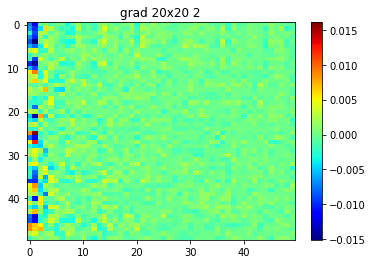

number of nonzero  tensor(327049)


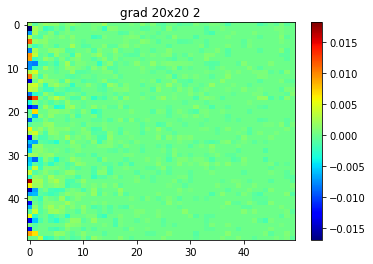

number of nonzero  tensor(230727)


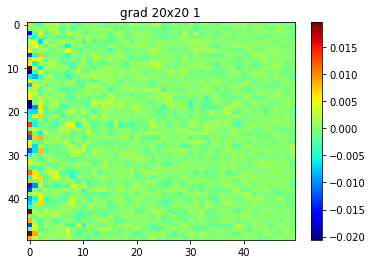

number of nonzero  tensor(388672)


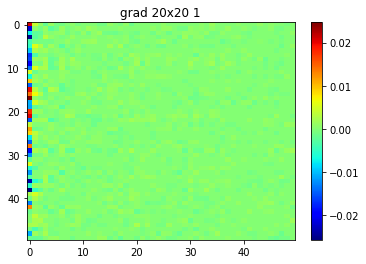

number of nonzero  tensor(212575)


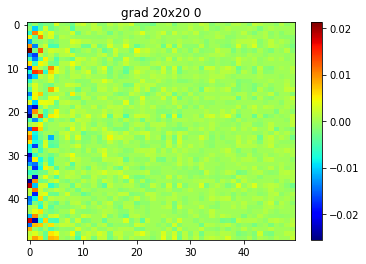

number of nonzero  tensor(447865)


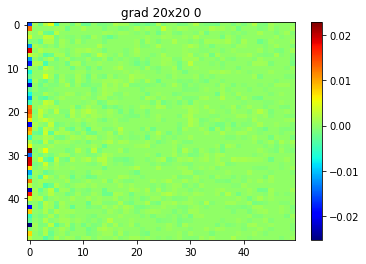

finishing collecting gradients


In [22]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [24]:
trainer.evaluate()

{'eval_loss': 0.5813707113265991,
 'eval_pearson': 0.8718921337736855,
 'eval_spearmanr': 0.8665849228919825,
 'eval_combined_score': 0.869238528332834,
 'eval_runtime': 4.6489,
 'eval_samples_per_second': 322.656,
 'eval_steps_per_second': 2.581,
 'epoch': 2.0}

In [25]:
eval_losses = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]
import pickle
with open('./stsb_pickles/sparse_bert00001_eval.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [26]:
import pickle
with open('./stsb_pickles/sparse_bert00001.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

# graphics

In [2]:
import pickle
a = pickle.load( open( "./stsb_pickles/sparse_bert0001_eval.pkl", "rb" ) ) 
b = pickle.load( open( "./stsb_pickles/sparse_bert00001_eval.pkl", "rb" ) ) 
c = pickle.load( open( "./stsb_pickles/sparse_bert_eval.pkl", "rb" ) ) 
d = pickle.load( open( "./stsb_pickles/bert_eval.pkl", "rb" ) ) 
e = pickle.load( open( "./stsb_pickles/sparse_bert01_eval.pkl", "rb" ) ) 

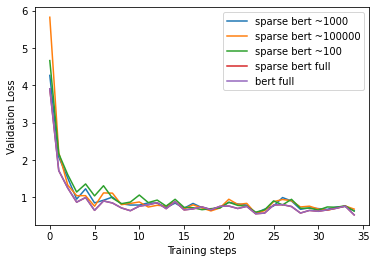

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.mean(np.array(a)[:350].reshape(-1, 10), axis=1), label = "sparse bert ~1000")
plt.plot(np.mean(np.array(b)[:350].reshape(-1, 10), axis=1), label = "sparse bert ~100000")
plt.plot(np.mean(np.array(e)[:350].reshape(-1, 10), axis=1), label = "sparse bert ~100")
plt.plot(np.mean(np.array(c)[:350].reshape(-1, 10), axis=1), label = "sparse bert full")
plt.plot(np.mean(np.array(c)[:350].reshape(-1, 10), axis=1), label = "bert full")

plt.xlabel("Training steps")
plt.ylabel("Validation Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import pickle
a = pickle.load( open( "./stsb_pickles/sparse_bert0001_eval.pkl", "rb" ) ) 
b = pickle.load( open( "./stsb_pickles/sparse_bert00001_eval.pkl", "rb" ) ) 
c = pickle.load( open( "./stsb_pickles/sparse_bert_eval.pkl", "rb" ) ) 
d = pickle.load( open( "./stsb_pickles/bert_eval.pkl", "rb" ) ) 
e = pickle.load( open( "./stsb_pickles/sparse_bert01_eval.pkl", "rb" ) ) 